In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt


## MD Program - Verlet Algorithm
### Note this is a unitless system (m and k are set to be 1)

1) Initialize System

* Set initial positions

* Generate random initial velocities

* Re-scale velocities 3/2*m*v^2=1/2*kT (for 3-D system)

2) Evaluate Forces At Current Position

* E = U(x)

* F = -dU/dx

3) Integrate EOM one step in time (Verlet Algorithm)

* x_i+1 = 2 * x_i - x_i-1 + dt^2 * F

4) Repeat Steps 2 & 3 until number of steps fulfilled

5) Analyze Trajectory (RMSD, Cv, etc.)

In [2]:
def init(temp,dt):
    
    xi=np.random.rand(1) # generate random configuration
    vi=np.random.randn(1) # generate random velocity
    sumv=vi
    sumv2=vi**2
    scale_factor=np.sqrt(1*temp/sumv2) # calculate scale factor for temperature
    vi=vi*scale_factor # re-scale velocity to temperature (via equipartition theorem)
    xprev=xi-vi*dt # estimate previous location using velocity
    return xi,xprev,vi

In [3]:
def calcforce(xi):
    ener=0.5*(xi-1)**2# calculate energy (harmonic oscillator)
    force=(-1*xi+1) # -dU/dx
    return ener,force

In [12]:
def integrate(xi,xprev,force,epot,delt):
    newx=xi*2-xprev+force*delt**2 # verlet algorithm
    newv=(newx-xprev)/(2*delt) # estimate new velocity 
    temp=newv**2 # calculate temperature assume m,k=1 and 1-D so 1/2T=1/2v^2
    etot=calcforce(newx)[0]+0.5*newv**2 # Total = Potential + Kinetic
    kin=0.5*newv**2 # Kinetic Energy = 1/2v^2
    return newx,temp,etot,kin

In [13]:
# Initialize
%matplotlib inline
base=np.arange(-5,5,0.01)
positions=np.zeros(50000)
temp=np.zeros(len(positions))
etot=np.zeros(len(positions))
eptot=np.zeros(len(positions))
ekin=np.zeros(len(positions))

temp[0]=1 #change
dt=0.001 #change
#npdb.set_trace()
x0,xp,v0=init(temp[0],dt)
velocities=np.zeros(len(positions))

#positions[0]=xp
positions[0]=x0
velocities[0]=v0

eptot[0]=calcforce(xp)[0]
ekin[0]=v0**2*0.5
etot[0]= eptot[0]+ekin[0]

for i in range(0,len(positions)-1):
    enp,fc=calcforce(positions[i]) 
    #pdb.set_trace()
    eptot[i]=enp
    if i==0:
        newx,newtemp,newetot,newkin=integrate(positions[i],xp,fc,enp,dt)
    else:
        newx,newtemp,newetot,newkin=integrate(positions[i],positions[i-1],fc,enp,dt)
    positions[i+1]=newx
    ekin[i+1]=newkin
    etot[i+1]=newetot
    temp[i+1]=newtemp
#     plt.clf()
#     plt.plot(base,0.5*(base-1)**2)
#     plt.plot(newx,calcforce(newx)[0])
#     plt.draw()
#     plt.pause(1)
eptot[-1]=calcforce(positions[-1])[0]

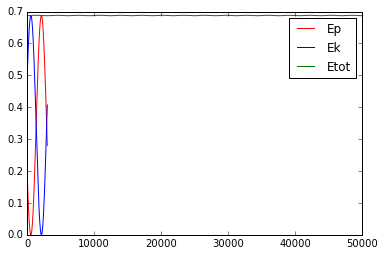

In [18]:
%matplotlib inline
plt.plot(eptot[:3000],'r',label='Ep')
plt.plot(ekin[:3000],'b',label='Ek')
plt.plot(etot,'g',label='Etot')
plt.legend()

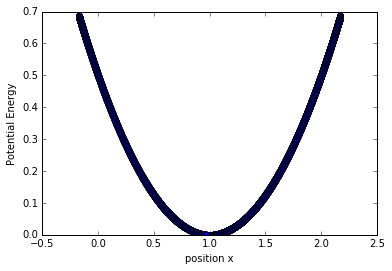

In [15]:
plt.plot(positions[:10000],eptot[:10000],'o')
plt.xlabel('position x')
plt.ylabel('Potential Energy')

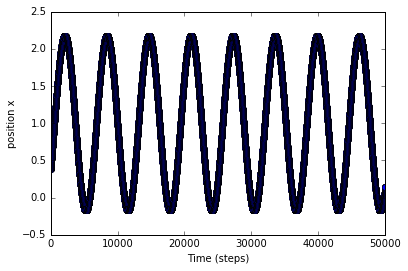

In [16]:
plt.plot(positions,'o')
plt.ylabel('position x')
plt.xlabel('Time (steps)')

In [17]:
etot[:10]

array([ 0.6880618 ,  0.68714304,  0.68714367,  0.6871443 ,  0.68714493,
        0.68714557,  0.68714621,  0.68714685,  0.68714749,  0.68714814])

## Key Questions

1) Change the timestep (increase &  decrease), what happens?

2) Change the temperature (increase & decrease, what happens?

3) As currently setup this integrator acting on an analytical potential will not break. 
But the potential energy function is a harmonic oscillator, which is an actual representation
of the energy between bonded atoms. Does this mean that this integrator will always work for
this potential (no drift, never crash)? 

4) What is missing in this representation which would cause problems? TO rephrase: what is the difference between this model, analytical potential and REAL molecular system?

In [9]:
etot[:10]

array([ 0.62814789,  0.62789479,  0.62789479,  0.62789479,  0.62789479,
        0.62789479,  0.62789479,  0.62789479,  0.62789479,  0.62789479])

## Calculate Cv

Cv = dE/dT

For NVE, E is constant but fluctuations of kinetic and potential energy are the same.

Cv can be evaluated from the fluations in kinetic energy. 

Ave(dK^2) = (ave(K^2) - ave(K)^2) = 3/2 * N * k^2 * T^2 * (1 - 3/2 * N * k / Cv)

Cv = (3 k /2) / (1 - (ave(K^2) - ave(K)^2)* (2/3) * N / (k^2 T^2))